Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

Code to check which mask is which class

Configs

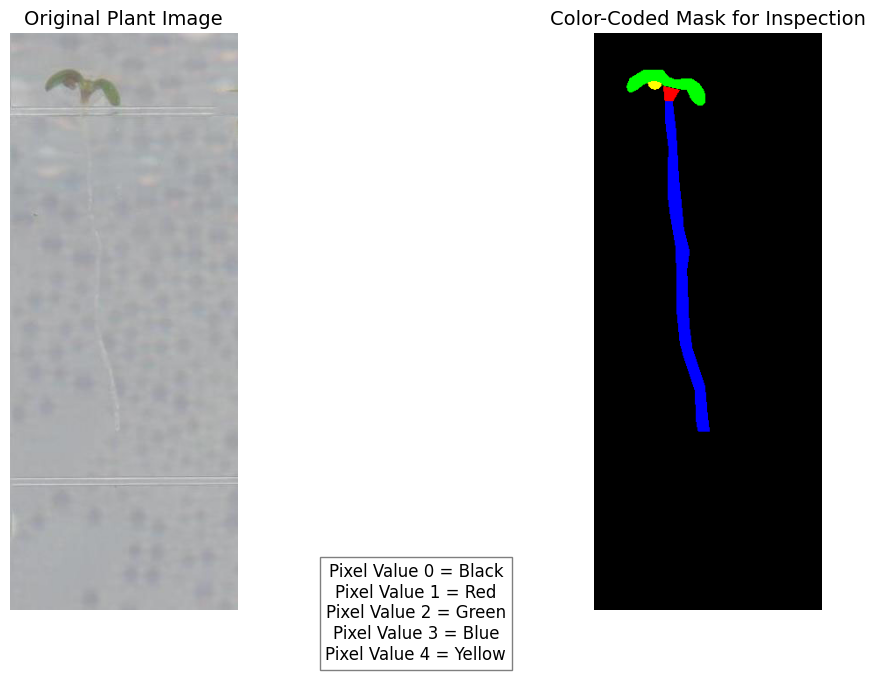

In [2]:
from PIL import Image

ORIGINAL_IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/images/Rep1_0.5%Sucrose_gaut3-1_4.jpg" # Change if needed
MASK_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/masks/Rep1_0.5%Sucrose_gaut3-1_4_mask.png"


INVESTIGATIVE_COLOR_MAP = {
    0: [0, 0, 0],       # Black
    1: [255, 0, 0],     # Red
    2: [0, 255, 0],     # Green
    3: [0, 0, 255],     # Blue
    4: [255, 255, 0],   # Yellow
}

try:
    # Load the original image and the mask
    original_image = Image.open(ORIGINAL_IMAGE_PATH)
    mask = cv2.imread(MASK_PATH, cv2.IMREAD_UNCHANGED)

    if mask is None:
        print(f"Error: Could not read mask at {MASK_PATH}")
    else:
        # Create an empty, black RGB image with the same dimensions as the mask
        color_coded_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

        # Apply our investigative colors
        for class_id, color in INVESTIGATIVE_COLOR_MAP.items():
            # Find all pixels in the mask that have this class_id and apply the color
            color_coded_mask[mask == class_id] = color

        # --- Display the results side-by-side ---
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        axes[0].imshow(original_image)
        axes[0].set_title("Original Plant Image", fontsize=14)
        axes[0].axis('off')

        axes[1].imshow(color_coded_mask)
        axes[1].set_title("Color-Coded Mask for Inspection", fontsize=14)
        axes[1].axis('off')

        # Add a helpful legend
        legend_text = "\n".join([f"Pixel Value {k} = {['Red', 'Green', 'Blue', 'Yellow'][k-1] if k>0 else 'Black'}" for k in np.unique(mask)])
        fig.text(0.5, 0.05, legend_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout(rect=[0, 0.1, 1, 1])
        plt.show()

except Exception as e:
    print(f"An error occurred. Check your file paths. Error: {e}")

In [3]:
DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/"
MASK_DIR = os.path.join(DRIVE_PATH, "masks")
CLASS_MAP = {
    0: "Background",
    1: "Stem",
    2: "Leaf",
    3: "Root",
    4: "Seed",
}

In [4]:
MASK_FILE_TO_CHECK = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/masks/Rep1_0.5%Sucrose_gaut3-1_4_mask.png"

try:
    # Read the mask image in its original grayscale format
    mask = cv2.imread(MASK_FILE_TO_CHECK, cv2.IMREAD_UNCHANGED)

    if mask is None:
        print(f"Error: Could not read the image file at {MASK_FILE_TO_CHECK}")
        print("Please double-check the file path and name.")
    else:
        # Find all the unique pixel values present in the mask
        unique_pixel_values = np.unique(mask)

        print(f"Analysis of mask: {MASK_FILE_TO_CHECK}")
        print("--------------------------------------------------")
        print("Found the following unique pixel values (class IDs):")
        print(unique_pixel_values)

except Exception as e:
    print(f"An error occurred: {e}")

Analysis of mask: /content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/masks/Rep1_0.5%Sucrose_gaut3-1_4_mask.png
--------------------------------------------------
Found the following unique pixel values (class IDs):
[0 1 2 3 4]


In [5]:
def analyze_pixel_distribution(mask_dir, class_map):
    """
    Counts the number of pixels for each class in every mask within a directory.

    Returns:
        A pandas DataFrame with pixel counts for each mask.
    """
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.tif'))]

    # List to hold the data for each mask
    pixel_data = []

    print(f"Analyzing {len(mask_files)} masks...")
    for filename in tqdm(mask_files):
        mask_path = os.path.join(mask_dir, filename)

        # Read the mask image in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"Warning: Could not read mask {filename}")
            continue

        # Dictionary to store counts for the current mask
        counts = {'filename': filename}

        # Get unique pixel values (class IDs) and their counts
        unique_classes, class_counts = np.unique(mask, return_counts=True)

        # Populate the dictionary with counts for each class
        for class_id, class_name in class_map.items():
            # Check if the class exists in the current mask
            if class_id in unique_classes:
                # Find the index of the class_id to get its count
                idx = np.where(unique_classes == class_id)[0][0]
                counts[class_name] = class_counts[idx]
            else:
                # If a class is not present in the mask, its count is 0
                counts[class_name] = 0

        pixel_data.append(counts)

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(pixel_data)
    return df

Analyzing 515 masks...


100%|██████████| 515/515 [00:20<00:00, 24.59it/s]



--- Descriptive Statistics (Pixel Counts per Image) ---
          Background         Stem         Leaf         Root         Seed
count     515.000000   515.000000   515.000000   515.000000   515.000000
mean   164699.673786   319.029126  1503.207767  3865.351456   232.355340
std      8894.052826   141.960170   674.145969  2185.620831   143.672942
min     16128.000000     0.000000     0.000000     0.000000     0.000000
25%    163471.000000   228.500000   959.000000  1801.500000   162.500000
50%    165303.000000   296.000000  1476.000000  3976.000000   247.000000
75%    168041.000000   376.000000  1984.500000  5523.500000   323.000000
max    171411.000000  1148.000000  4748.000000  9562.000000  1221.000000

Generating boxplots...


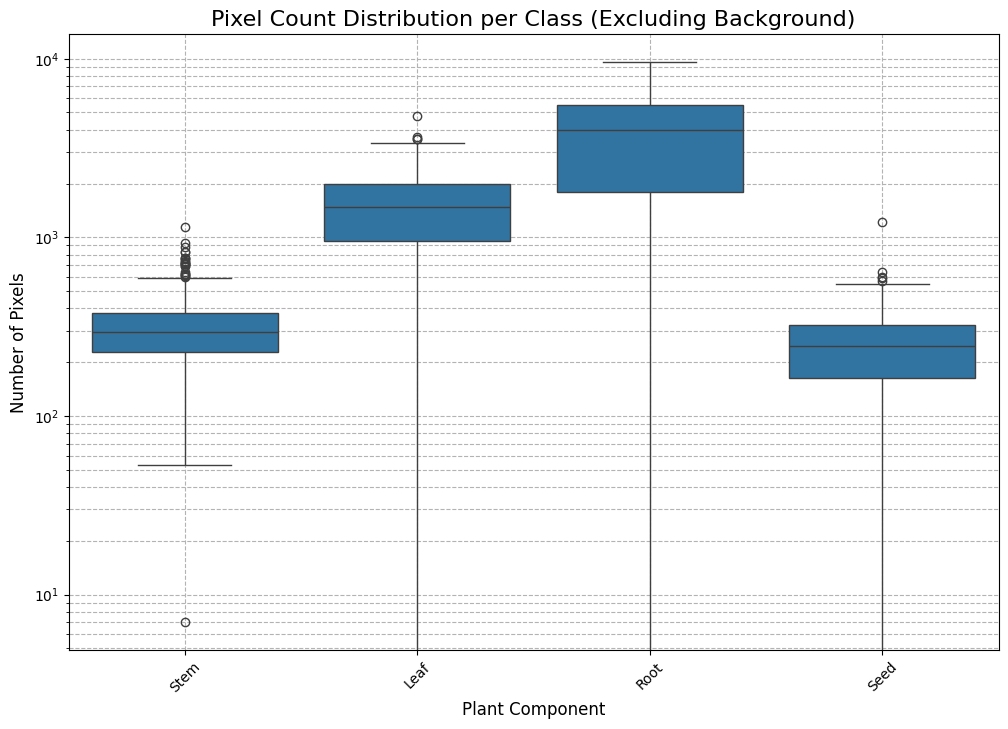

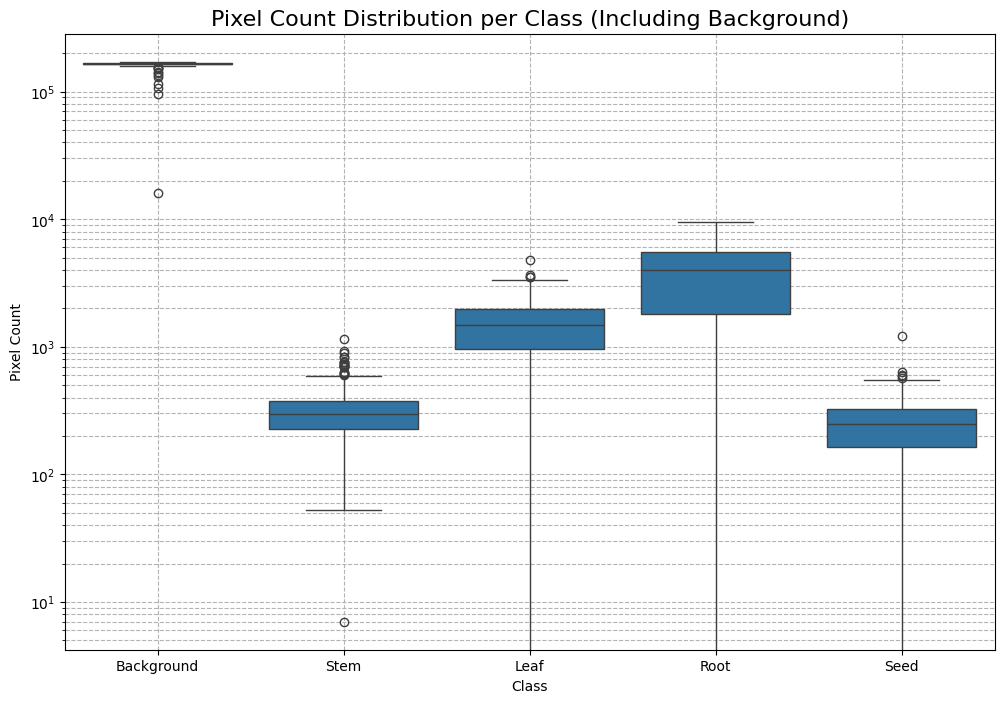

In [6]:
# Run the analysis
pixel_df = analyze_pixel_distribution(MASK_DIR, CLASS_MAP)

# --- Display Descriptive Statistics (Tabular Format) ---
print("\n--- Descriptive Statistics (Pixel Counts per Image) ---")
# describe() gives you count, mean, std, min, quartiles, and max
stats_table = pixel_df.describe()
print(stats_table)

# --- Create Boxplots for Distribution Visualization ---
print("\nGenerating boxplots...")

# To make the boxplot readable, we'll exclude the 'Background' class
# as its scale will squash all the other plots.
df_for_plot = pixel_df.drop(columns=['filename', 'Background'])

# "Melt" the DataFrame to a long format suitable for seaborn
df_melted = df_for_plot.melt(var_name='Class', value_name='Pixel Count')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Class', y='Pixel Count', data=df_melted)
plt.title('Pixel Count Distribution per Class (Excluding Background)', fontsize=16)
plt.xlabel('Plant Component', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log') # Use a log scale because counts can vary wildly
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

# You can also create a boxplot including the background to show its dominance
plt.figure(figsize=(12, 8))
sns.boxplot(x='Class', y='Pixel Count', data=pixel_df.melt(id_vars=['filename'], var_name='Class', value_name='Pixel Count'))
plt.title('Pixel Count Distribution per Class (Including Background)', fontsize=16)
plt.yscale('log')
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
# Path to your masks
MASK_DIR = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/masks"

# Where to save the report
OUTPUT_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/missing_classes_report.csv"

# Your CORRECTED Class Map
CLASS_MAP = {
    0: "Background",
    1: "Stem",
    2: "Leaf",
    3: "Root",
    4: "Seed",
}

# ==============================================================================
# 2. ANALYSIS SCRIPT
# ==============================================================================
def analyze_missing_classes():
    print(f"Scanning masks in: {MASK_DIR}")

    mask_files = [f for f in os.listdir(MASK_DIR) if f.endswith(('.png', '.jpg', '.tif', '.bmp'))]

    # List to store detailed rows for the CSV
    csv_data = []

    # Dictionary to store total counts (e.g., {'Seed': 30, 'Leaf': 2})
    # We filter out Background (0) because we assume it's always there
    global_missing_counts = {name: 0 for id, name in CLASS_MAP.items() if id != 0}

    total_masks_checked = 0
    masks_with_missing_content = 0

    for filename in tqdm(mask_files, desc="Analyzing masks"):
        mask_path = os.path.join(MASK_DIR, filename)

        # Read mask in grayscale (0-255)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"Warning: Could not read {filename}")
            continue

        total_masks_checked += 1

        # Get unique pixel values present in this mask
        present_values = np.unique(mask)

        missing_in_this_image = []

        # Check for each class (skipping Background)
        for class_id, class_name in CLASS_MAP.items():
            if class_id == 0:
                continue

            if class_id not in present_values:
                missing_in_this_image.append(class_name)
                global_missing_counts[class_name] += 1

        # If we found missing classes, add to our CSV list
        if missing_in_this_image:
            masks_with_missing_content += 1
            csv_data.append({
                "filename": filename,
                "missing_classes": ", ".join(missing_in_this_image),
                "count_missing": len(missing_in_this_image)
            })

    # ==========================================================================
    # 3. GENERATE OUTPUTS
    # ==========================================================================

    # --- A. Save CSV ---
    if csv_data:
        df = pd.DataFrame(csv_data)
        # Sort by filename for neatness
        df = df.sort_values(by="filename")
        df.to_csv(OUTPUT_CSV_PATH, index=False)
        print(f"\n Detailed report saved to: {OUTPUT_CSV_PATH}")
    else:
        print("\n No missing classes found in any images.")

    # --- B. Print Summary Stats ---
    print("\n" + "="*40)
    print("MISSING CLASS SUMMARY")
    print("="*40)
    print(f"Total Images Analyzed: {total_masks_checked}")
    print(f"Images with at least one missing part: {masks_with_missing_content}")
    print("-" * 40)
    print("Breakdown by Class (How many images are missing this part?):")

    # Sort by count (highest missing first)
    sorted_counts = sorted(global_missing_counts.items(), key=lambda x: x[1], reverse=True)

    for class_name, count in sorted_counts:
        percent = (count / total_masks_checked) * 100 if total_masks_checked > 0 else 0
        print(f"  {class_name:<10}: Missing in {count} images ({percent:.1f}%)")
    print("="*40)

if __name__ == "__main__":
    analyze_missing_classes()

Isolate Images with potetially wrong masks.

In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
# Base path
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/"

# Inputs
SOURCE_IMAGE_DIR = os.path.join(BASE_PATH, "images")
MISSING_REPORT_CSV = os.path.join(BASE_PATH, "missing_classes_report.csv")

# Output: Where to copy the problematic images
DEST_DIR = os.path.join(BASE_PATH, "problematic_images_inspection")

# ==============================================================================
# 2. ISOLATION SCRIPT
# ==============================================================================
def isolate_images():
    # --- Check Inputs ---
    if not os.path.exists(MISSING_REPORT_CSV):
        print(f"Error: CSV file not found at {MISSING_REPORT_CSV}")
        return

    # Create destination directory
    os.makedirs(DEST_DIR, exist_ok=True)
    print(f"Created destination folder: {DEST_DIR}")

    # Load the report
    print(f"Reading report from: {MISSING_REPORT_CSV}")
    df = pd.read_csv(MISSING_REPORT_CSV)

    # Get the list of mask filenames
    mask_filenames = df['filename'].tolist()
    print(f"Found {len(mask_filenames)} entries in the report.")

    success_count = 0
    missing_count = 0

    print("\n--- Starting Copy Process ---")
    for mask_name in tqdm(mask_filenames):
        # --- Logic: Convert Mask Filename to Image Filename ---
        # User Instruction: remove "_mask.png" and replace with ".jpg"
        if mask_name.endswith("_mask.png"):
            image_name = mask_name.replace("_mask.png", ".jpg")
        else:
            # Fallback for weird naming (just swap extension)
            base_name = os.path.splitext(mask_name)[0]
            # Try to strip _mask if it exists in a different format
            if base_name.endswith("_mask"):
                base_name = base_name[:-5]
            image_name = base_name + ".jpg"

        # Define source and destination paths
        src_path = os.path.join(SOURCE_IMAGE_DIR, image_name)
        dst_path = os.path.join(DEST_DIR, image_name)

        # --- Copy File ---
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
            success_count += 1
        else:

            print(f"Warning: Original image not found for mask {mask_name} (Expected: {image_name})")
            missing_count += 1

    print("\n" + "="*40)
    print("ISOLATION COMPLETE")
    print("="*40)
    print(f"Successfully copied: {success_count} images")
    print(f"Not found: {missing_count} images")
    print(f"Files are located in: {DEST_DIR}")

if __name__ == "__main__":
    isolate_images()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
# Base path
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/"

# Input Paths
SOURCE_IMAGE_DIR = os.path.join(BASE_PATH, "images")
SOURCE_MASK_DIR = os.path.join(BASE_PATH, "masks")
MISSING_REPORT_CSV = os.path.join(BASE_PATH, "missing_classes_report.csv")

# Output Paths
OUTPUT_BASE_DIR = os.path.join(BASE_PATH, "synthetic_data")
OUTPUT_IMG_DIR = os.path.join(OUTPUT_BASE_DIR, "images")
OUTPUT_MASK_DIR = os.path.join(OUTPUT_BASE_DIR, "masks")

# Settings
SAMPLES_PER_CLASS = 20  # How many images to generate for each removed class

# Classes to systematically remove (Background is 0, so we skip it)
# We use the CORRECTED mapping: {1: Stem, 2: Leaf, 3: Root, 4: Seed}
CLASSES_TO_REMOVE = {
    1: "Stem",
    2: "Leaf",
    3: "Root",
    4: "Seed"
}

# ==============================================================================
# 2. GENERATION SCRIPT
# ==============================================================================
def create_synthetic_data():
    # --- Step 1: Load the Exclusion List ---
    if not os.path.exists(MISSING_REPORT_CSV):
        print(f"Error: CSV file not found at {MISSING_REPORT_CSV}")
        print("Please run the 'missing_class_analysis.py' script first.")
        return

    print(f"Loading exclusion list from: {MISSING_REPORT_CSV}")
    df = pd.read_csv(MISSING_REPORT_CSV)

    # Create a set of mask filenames that have missing parts
    # We use a set for O(1) fast lookups
    excluded_mask_filenames = set(df['filename'].tolist())
    print(f"Found {len(excluded_mask_filenames)} images with missing classes. These will be excluded.")

    # --- Step 2: Filter Source Images ---
    all_image_files = [f for f in os.listdir(SOURCE_IMAGE_DIR) if f.endswith(('.jpg', '.png', '.tif'))]
    valid_source_images = []

    for img_file in all_image_files:
        # Construct the corresponding mask filename
        mask_name = os.path.splitext(img_file)[0] + "_mask.png"

        # CRITICAL CHECK:
        # 1. Mask must physically exist
        # 2. Mask must NOT be in the exclusion CSV
        mask_path = os.path.join(SOURCE_MASK_DIR, mask_name)

        if os.path.exists(mask_path) and (mask_name not in excluded_mask_filenames):
            valid_source_images.append(img_file)

    print(f"Total images found: {len(all_image_files)}")
    print(f"Valid 'Complete' images available for generation: {len(valid_source_images)}")

    if len(valid_source_images) < SAMPLES_PER_CLASS:
        print(f"Warning: You requested {SAMPLES_PER_CLASS} samples, but only have {len(valid_source_images)} valid images.")
        print("Reducing samples to match available images.")

    # Create output directories
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

    # --- Step 3: Generate Synthetic Data ---
    for class_id, class_name in CLASSES_TO_REMOVE.items():
        print(f"\n--- Generating Data: Removing Class '{class_name}' ({class_id}) ---")

        # Determine sample size (don't crash if we have fewer images than requested)
        current_sample_size = min(SAMPLES_PER_CLASS, len(valid_source_images))

        # Pick random images from the VALID list
        selected_files = random.sample(valid_source_images, current_sample_size)

        for filename in tqdm(selected_files):
            # Load Original
            img_path = os.path.join(SOURCE_IMAGE_DIR, filename)
            mask_name = os.path.splitext(filename)[0] + "_mask.png"
            mask_path = os.path.join(SOURCE_MASK_DIR, mask_name)

            image = cv2.imread(img_path) # BGR
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # --- A. Calculate Background Texture ---
            # Create a mask of the background (class 0)
            bg_mask = (mask == 0).astype(np.uint8)

            if np.sum(bg_mask) > 0:
                # Calculate mean color (B, G, R)
                bg_mean = cv2.mean(image, mask=bg_mask)[:3]
            else:
                bg_mean = (128, 128, 128)

            # --- B. Create Fill Texture (Solid Color) ---
            # Create a solid color image with the background mean
            fill_texture = np.full_like(image, bg_mean, dtype=np.uint8)
            # --- C. Identify Target Pixels ---
            class_pixels = (mask == class_id)
            if not np.any(class_pixels):
                continue

            # --- D. Apply Inpainting ---
            # Replace target pixels in image with texture
            image[class_pixels] = fill_texture[class_pixels]

            # Remove target pixels from mask (set to 0/Background)
            mask[class_pixels] = 0

            # --- E. Save ---
            name_root, name_ext = os.path.splitext(filename)
            new_filename = f"{name_root}_no_{class_name}{name_ext}"
            new_maskname = f"{name_root}_no_{class_name}_mask.png"

            cv2.imwrite(os.path.join(OUTPUT_IMG_DIR, new_filename), image)
            cv2.imwrite(os.path.join(OUTPUT_MASK_DIR, new_maskname), mask)

    print("\nSynthetic data generation complete!")
    print(f"Output Directory: {OUTPUT_BASE_DIR}")

if __name__ == "__main__":
    create_synthetic_data()

In [ ]:
import pandas as pd
import os

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/phenocyte_seg/phenocyte_seg/"

# Path to the file containing the Train/Val/Test split info
SPLIT_CSV_PATH = os.path.join(BASE_PATH, "dataset_split.csv")

# Path to the Quality Control CSV (The one with Mask_correct column)
QC_REPORT_CSV = os.path.join(BASE_PATH, "missing_classes_from_mask.csv")

# Output CSV to save the list of bad test images
OUTPUT_BAD_TEST_CSV = os.path.join(BASE_PATH, "bad_masks_in_test_set.csv")

# ==============================================================================
# 2. ANALYSIS SCRIPT
# ==============================================================================
def find_bad_test_images():
    print("--- Loading Data ---")

    # 1. Load Dataset Split
    try:
        df_split = pd.read_csv(SPLIT_CSV_PATH)
    except:
        df_split = pd.read_excel(SPLIT_CSV_PATH.replace('.csv', '.xlsx'))

    # Filter for ONLY the Test set
    test_images = df_split[df_split['set'] == 'test']['img_name'].tolist()
    print(f"Total images in Test Set: {len(test_images)}")

    # 2. Load QC Report (The Bad Masks)
    df_qc = pd.read_csv(QC_REPORT_CSV)

    # Filter for FALSE entries (Case insensitive check)
    bad_masks_df = df_qc[df_qc['Mask_correct'].astype(str).str.upper() == 'FALSE']
    bad_mask_filenames = set(bad_masks_df['filename'].tolist())
    print(f"Total masks marked 'FALSE' (Bad) in QC report: {len(bad_mask_filenames)}")

    # ==========================================================================
    # 3. CROSS-REFERENCE
    # ==========================================================================
    print("\n--- Cross-Referencing ---")

    bad_test_images = []

    for img_name in test_images:
        # We need to convert the Image Name (from split) to a Mask Name (from QC)
        # Standard logic: 'image.jpg' -> 'image_mask.png'

        # 1. Remove extension from image
        base_name = os.path.splitext(img_name)[0]

        # 2. Reconstruct mask name
        # We assume the QC report has names like 'Rep1..._mask.png'
        expected_mask_name = f"{base_name}_mask.png"

        # 3. Check if this mask is in the "Bad List"
        if expected_mask_name in bad_mask_filenames:
            bad_test_images.append({
                'img_name': img_name,
                'mask_name': expected_mask_name,
                'reason': 'Mask_correct = FALSE'
            })

    # ==========================================================================
    # 4. REPORTING
    # ==========================================================================
    if bad_test_images:
        print(f"FOUND {len(bad_test_images)} BAD IMAGES IN THE TEST SET")
        print("These images have masks marked as incorrect/false.")

        df_bad = pd.DataFrame(bad_test_images)
        print(df_bad)

        df_bad.to_csv(OUTPUT_BAD_TEST_CSV, index=False)
        print(f"\nSaved list to: {OUTPUT_BAD_TEST_CSV}")
        print("Recommendation: Exclude these from your final metrics calculation.")
    else:
        print("Great news! No images in your Test Set are marked as FALSE.")

if __name__ == "__main__":
    find_bad_test_images()